In [1]:
import torch
import matplotlib.pyplot as plt
import os 

# # Change the directory if required
# main_path = '/workspaces/ssa-solvers' 
# os.chdir(main_path) # project directory/

%load_ext line_profiler
%matplotlib inline

torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")


### testing direct vs first reaction

In [2]:
from circuits.mrna_srna.mrna_srna_intrans import mRNAsRNAInTrans, cfg

from ssa_solvers.simulators import StochasticSimulator, DeterministicSimulator 

end_time = 200
n_steps = 100
n_traj = 500


In [3]:
reaction_system = mRNAsRNAInTrans(device=device)
init_pops = torch.zeros((reaction_system.n_species, ), dtype=torch.int64, device=device) #torch.randint(1, (reaction_system.n_species, ))
time_grid = torch.arange(0, end_time, int(end_time / n_steps), device=device)
cfg['stochastic_sim_cfg']['save_to_file'] = False
# Specifying a simulator using direct method
cfg['stochastic_sim_cfg']['solver'] = 'direct'
cfg['stochastic_sim_cfg']['precision'] = 'fp16'
ssa_simulator_direct = StochasticSimulator(
    reaction_system=reaction_system,
    cfg=cfg,
    device=device
)
# Specifying a simulator using first reaction method
cfg2 = cfg.copy()
cfg2['stochastic_sim_cfg']['solver'] = 'first_reaction'
ssa_simulator_fr = StochasticSimulator(
    reaction_system=reaction_system,
    cfg=cfg2,
    device=device
)

In [4]:
%timeit ssa_simulator_fr.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
%timeit ssa_simulator_direct.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

939 ms ± 218 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
849 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parameters for deterministic simulations 

In [5]:
reaction_system = mRNAsRNAInTrans(device=device)
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system,
    cfg=cfg
)
ode_res = ode_simulator.simulate(init_pops=init_pops, time_grid=time_grid)

### Plotting results for verification

Comptuting the statistics on a grid

In [6]:
means_direct, stds_direct = ssa_simulator_direct.data_set.mean_and_std(time_grid=time_grid)
means_fr, stds_fr = ssa_simulator_fr.data_set.mean_and_std(time_grid=time_grid)

Plotting

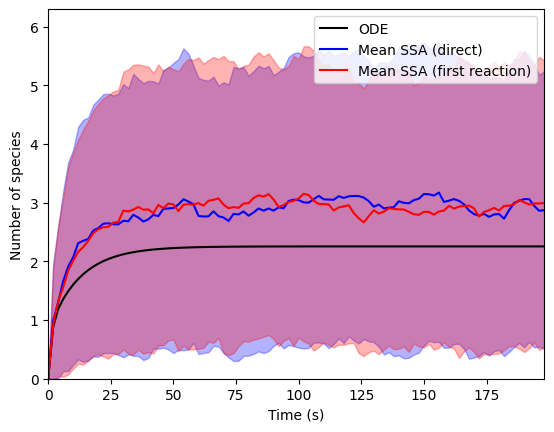

In [7]:
time_grid = time_grid.cpu()
species_idx = 1
plt.figure()
# ode
plt.plot(time_grid, ode_res[species_idx, :], 'k', label='ODE')
# direct ssa 
plt.plot(time_grid, means_direct[species_idx, :], 'b', label='Mean SSA (direct)')
plt.fill_between(time_grid, means_direct[species_idx,:]+stds_direct[species_idx, :], means_direct[species_idx,:]-stds_direct[species_idx, :], 
                 color='b', alpha=0.3)
plt.xlim([0, end_time])    

plt.xlabel('Time (s)')
plt.ylabel('Number of species')
# first reaction ssa
plt.plot(time_grid, means_fr[species_idx, :], 'r', label='Mean SSA (first reaction)')
plt.fill_between(time_grid, means_fr[species_idx,:]+stds_fr[species_idx, :], means_fr[species_idx,:]-stds_fr[species_idx, :], 
                 color='r',alpha=0.3)
plt.xlim([0, end_time])    
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
plt.xlim([0, max(time_grid)])
plt.ylim([0, 1.1 * max([(means_direct[species_idx,:]+stds_direct[species_idx, :]).max(), 
                        (means_fr[species_idx,:]+stds_fr[species_idx, :]).max()])])
plt.legend()

### CPU vs GPU

In [8]:
from circuits.auto_repressor.tetr_srna_incis import TetRsRNAInCis, cfg
cfg['stochastic_sim_cfg']['save_to_file'] = False

device = torch.device("cuda:0")
reaction_system_c = TetRsRNAInCis(device=device)
init_pops_c = torch.zeros((reaction_system_c.n_species, ), dtype=torch.int64, device=device) 
ssa_simulator_c = StochasticSimulator(
    reaction_system=reaction_system_c,
    cfg=cfg,
    device=device
)

device = torch.device("cpu")
reaction_system = TetRsRNAInCis(device=device)
init_pops = torch.zeros((reaction_system.n_species, ), dtype=torch.int64, device=device) 
ssa_simulator = StochasticSimulator(
    reaction_system=reaction_system,
    cfg=cfg,
    device=device
)

In [9]:
n_traj = 100
end_time = 200
%timeit ssa_simulator_c.simulate(init_pops=init_pops_c, end_time=end_time, n_trajectories=n_traj)
%timeit ssa_simulator.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

336 ms ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
154 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%time
n_traj = 1000
end_time = 300
ssa_simulator_c.simulate(init_pops=init_pops_c, end_time=end_time, n_trajectories=n_traj)

CPU times: user 527 ms, sys: 278 µs, total: 527 ms
Wall time: 497 ms


In [11]:
%%time
n_traj = 1000
end_time = 300
ssa_simulator.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)


CPU times: user 2.06 s, sys: 35.3 ms, total: 2.1 s
Wall time: 542 ms
